## **Credit Default Prediction**

### **Business Problem**
Financial institutions need to **predict credit default risk** to minimize losses. The goal of this project is to analyze borrower data and identify key risk factors that influence default likelihood.

# Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import scipy.stats as stats
import os
import joblib
%matplotlib inline

# Load dataset

In [2]:
# Load dataset
df_train = pd.read_csv("cs-training.csv")
df_test = pd.read_csv("cs-test.csv")

df_test.drop(columns=["Default"], inplace=True)

In [3]:
full_data = pd.concat([df_train, df_test], axis=0)

In [4]:
# shuffle the data
full_data = full_data.sample(frac=1).reset_index(drop=True)

In [5]:
df_train.shape, full_data.shape, df_test.shape

((150000, 11), (251503, 11), (101503, 10))

## Drop NaN Values in Default Column

In [6]:
# Convert empty strings to NaN (if necessary)
full_data["Default"] = full_data["Default"].replace("", pd.NA)

# Drop rows where 'Default' is NaN
full_data = full_data.dropna(subset=["Default"])

print(full_data["Default"].isnull().sum())

0


In [8]:
df_train.shape, full_data.shape, df_test.shape

((150000, 11), (150000, 11), (101503, 10))

## Split the data into training and test sets

In [9]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [10]:
train_original, test_original = data_split(full_data, 0.2)

In [11]:
train_original.shape, test_original.shape

((120000, 11), (30000, 11))

In [12]:
train_original['Default'].value_counts()

Default
0.0    111962
1.0      8038
Name: count, dtype: int64

# Data Exploration

- Basic Data exploration
- Check for missing data
- Check for skewed features
- Check for Outliers

In [22]:
train_original.columns

Index(['Default', 'RevolvingUtil', 'age', 'PastDue30_59', 'DebtRatio',
       'Income', 'OpenCreditLines', 'PastDue90', 'RealEstateLoans',
       'PastDue60_89', 'Dependents'],
      dtype='object')

In [23]:
train_original.head()

,Default,RevolvingUtil,age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents
0,0.0,0.517404,63,0,0.180274,6711.0,4,0,1,0,1.0
1,0.0,0.150095,47,0,0.491564,8000.0,23,0,4,0,0.0
2,0.0,0.786979,37,0,0.549059,6430.0,15,0,1,0,3.0
3,0.0,0.592640,28,0,0.153521,4500.0,7,0,0,0,0.0
4,0.0,0.038257,47,0,0.658760,9400.0,7,0,3,0,3.0


In [13]:
# Check dataset shape
print(f"Dataset contains {train_original.shape[0]} rows and {train_original.shape[1]} columns.")

# Check column data types and missing values
print(train_original.info())

# Summary statistics
train_original.describe()

Dataset contains 120000 rows and 11 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Default          120000 non-null  float64
 1   RevolvingUtil    120000 non-null  float64
 2   age              120000 non-null  int64  
 3   PastDue30_59     120000 non-null  int64  
 4   DebtRatio        120000 non-null  float64
 5   Income           96265 non-null   float64
 6   OpenCreditLines  120000 non-null  int64  
 7   PastDue90        120000 non-null  int64  
 8   RealEstateLoans  120000 non-null  int64  
 9   PastDue60_89     120000 non-null  int64  
 10  Dependents       116855 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 10.1 MB
None


,Default,RevolvingUtil,age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,9.626500e+04,120000.000000,120000.000000,120000.000000,120000.000000,116855.000000
mean,0.066583,5.917845,52.276833,0.425633,354.737387,6.679681e+03,8.449483,0.270233,1.018075,0.245025,0.758376
std,0.249300,248.707644,14.774743,4.246676,2199.799543,1.429742e+04,5.139676,4.223396,1.125615,4.209919,1.114036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030038,41.000000,0.000000,0.175442,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154930,52.000000,0.000000,0.366540,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559871,63.000000,0.000000,0.862565,8.266000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,57.000000,98.000000,32.000000,98.000000,13.000000


In [14]:
# Check missing values
print(train_original.isnull().sum())

Default                0
RevolvingUtil          0
age                    0
PastDue30_59           0
DebtRatio              0
Income             23729
OpenCreditLines        0
PastDue90              0
RealEstateLoans        0
PastDue60_89           0
Dependents          3136
dtype: int64


In [26]:
def univariate_analysis(data):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Default', 'Dependents'], errors='ignore')

    for column in numeric_columns:
        print(f'\nAnalysis for {column}:\n')
        print(data[column].describe())
        
        plt.figure(figsize=(12, 6))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(f'Histogram of {column}')
        
        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=data[column])
        plt.title(f'Box Plot of {column}')
        
        plt.tight_layout()
        plt.show()


Analysis for RevolvingUtil:

count    120000.000000
mean          5.713987
std         246.744668
min           0.000000
25%           0.030118
50%           0.155343
75%           0.561115
max       50708.000000
Name: RevolvingUtil, dtype: float64


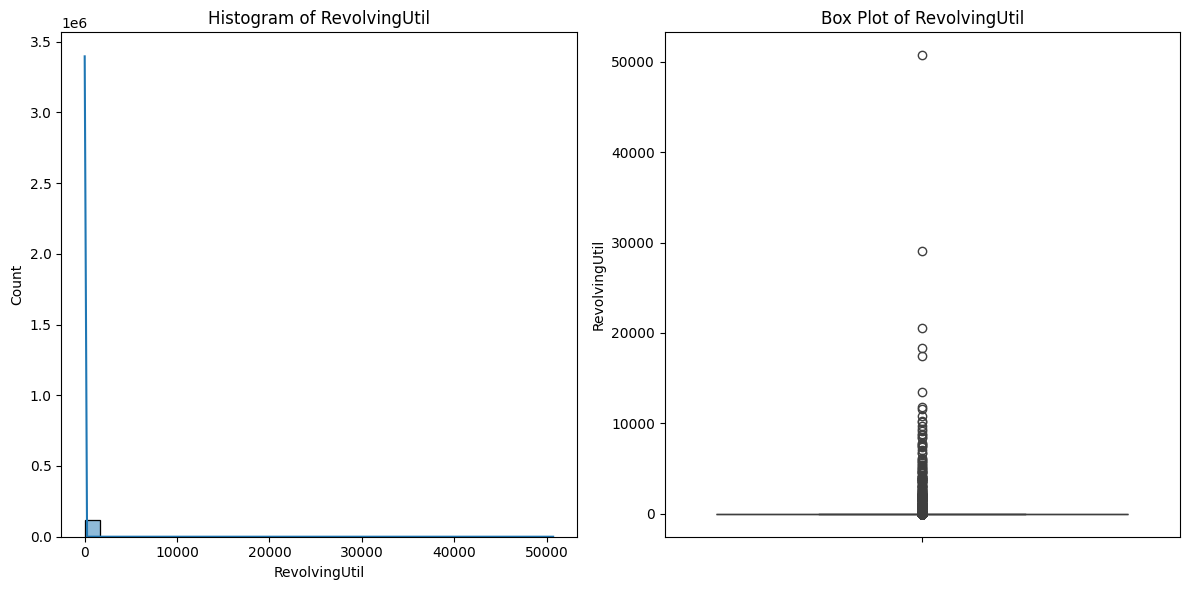


Analysis for age:

count    120000.000000
mean         52.283333
std          14.757795
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64


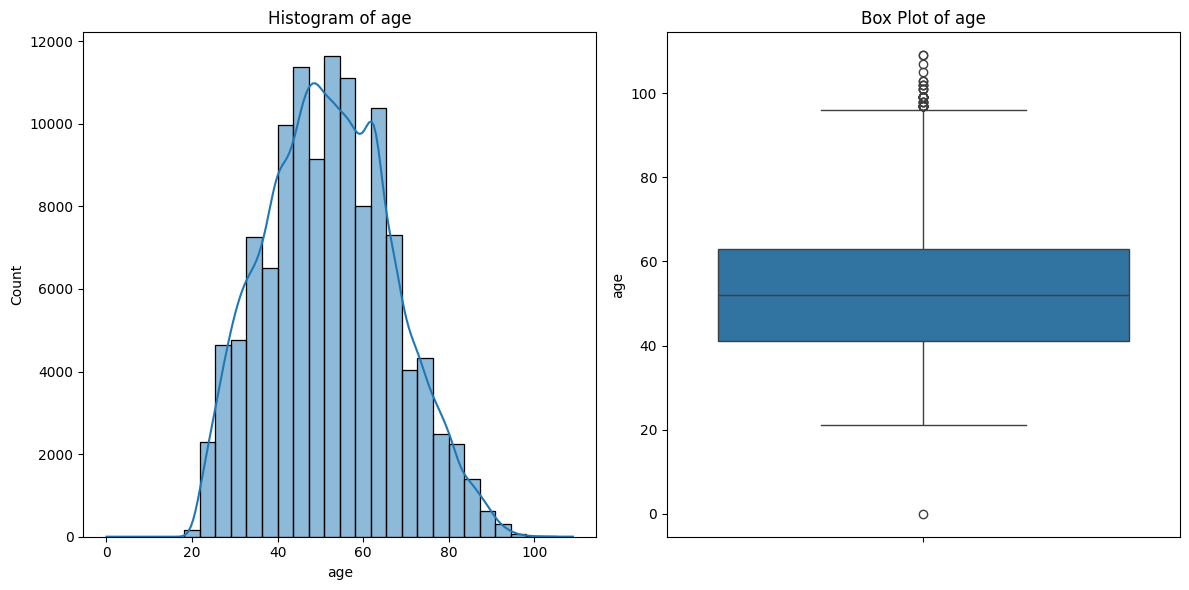


Analysis for PastDue30_59:

count    120000.000000
mean          0.420525
std           4.162939
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: PastDue30_59, dtype: float64


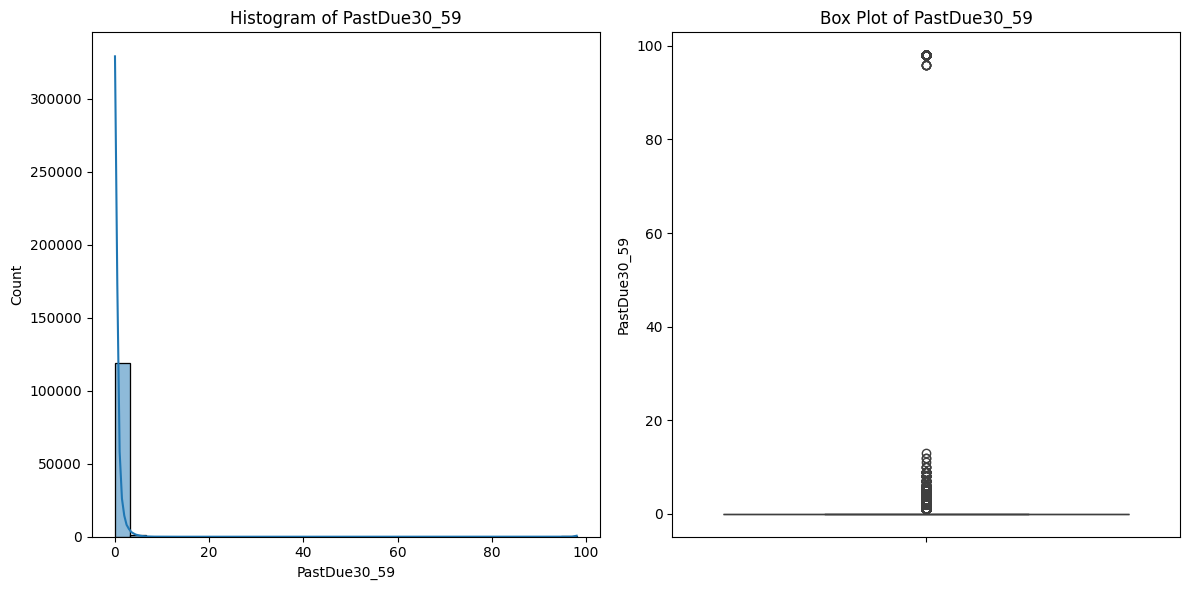


Analysis for DebtRatio:

count    120000.000000
mean        352.336730
std        1932.858029
min           0.000000
25%           0.175395
50%           0.366807
75%           0.868931
max      329664.000000
Name: DebtRatio, dtype: float64


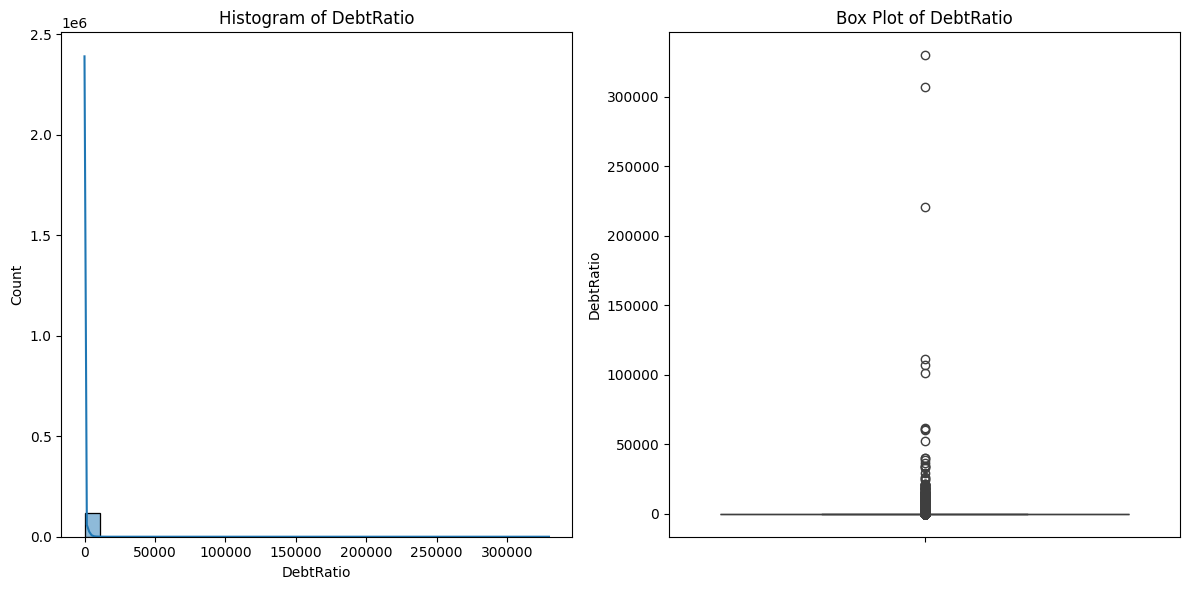


Analysis for Income:

count    9.620800e+04
mean     6.674620e+03
std      1.554219e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.240000e+03
max      3.008750e+06
Name: Income, dtype: float64


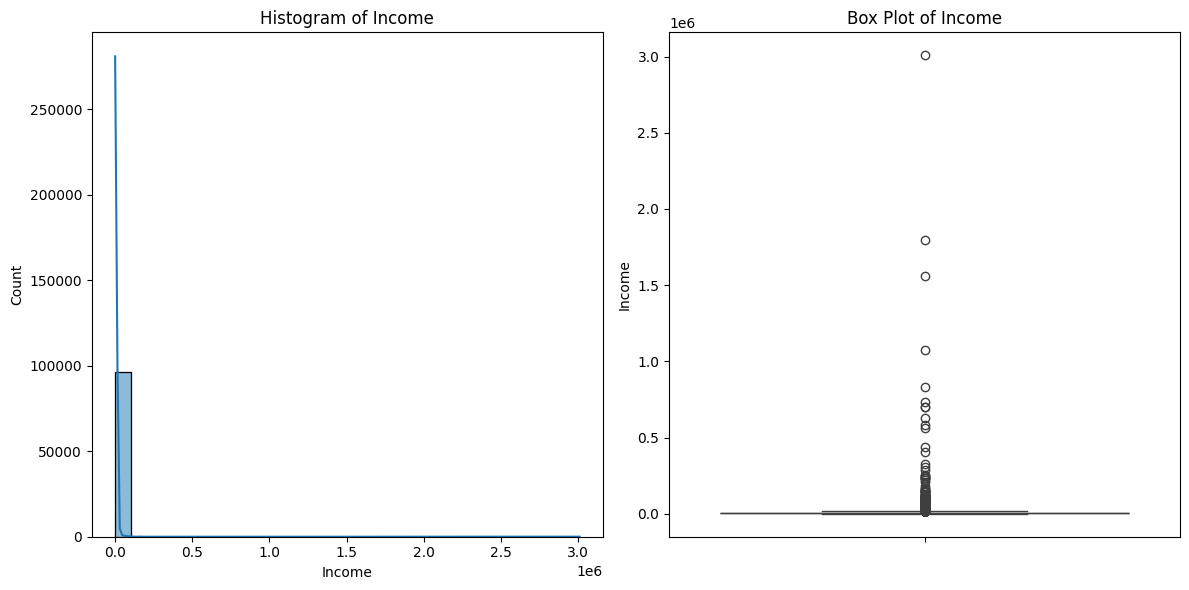


Analysis for OpenCreditLines:

count    120000.000000
mean          8.464733
std           5.169942
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: OpenCreditLines, dtype: float64


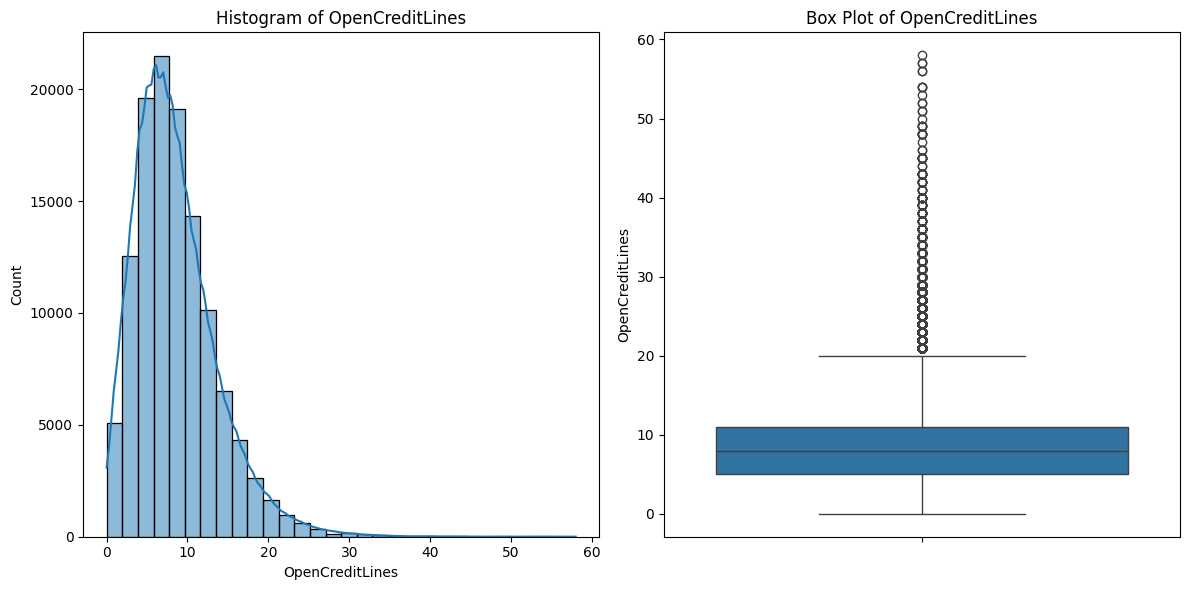


Analysis for PastDue90:

count    120000.000000
mean          0.263642
std           4.138131
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: PastDue90, dtype: float64


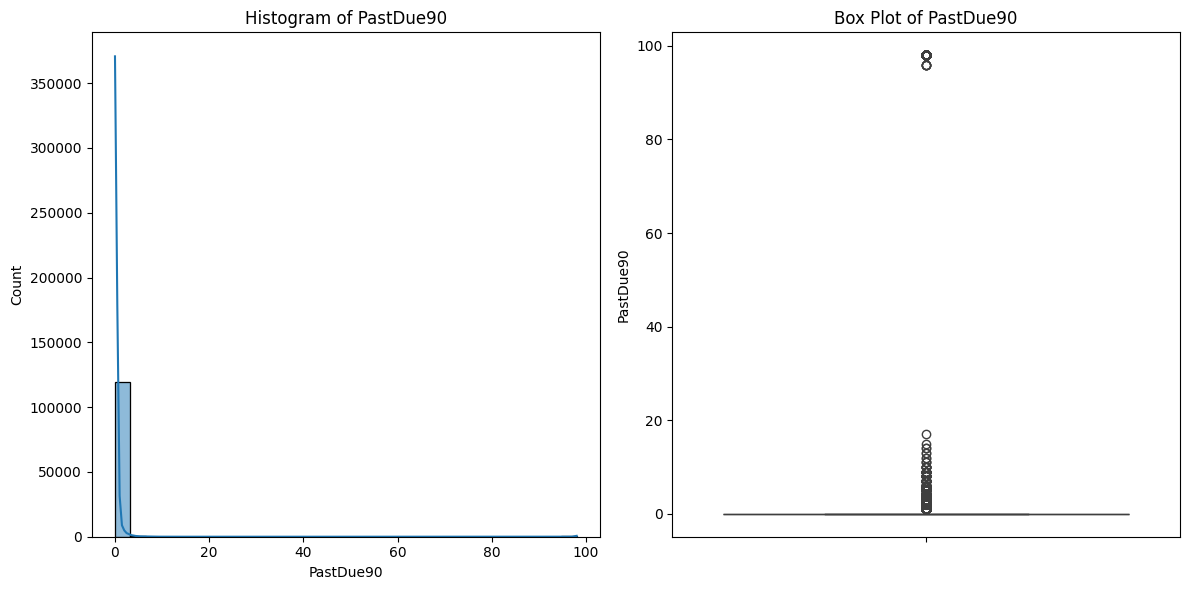


Analysis for RealEstateLoans:

count    120000.000000
mean          1.019475
std           1.139937
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: RealEstateLoans, dtype: float64


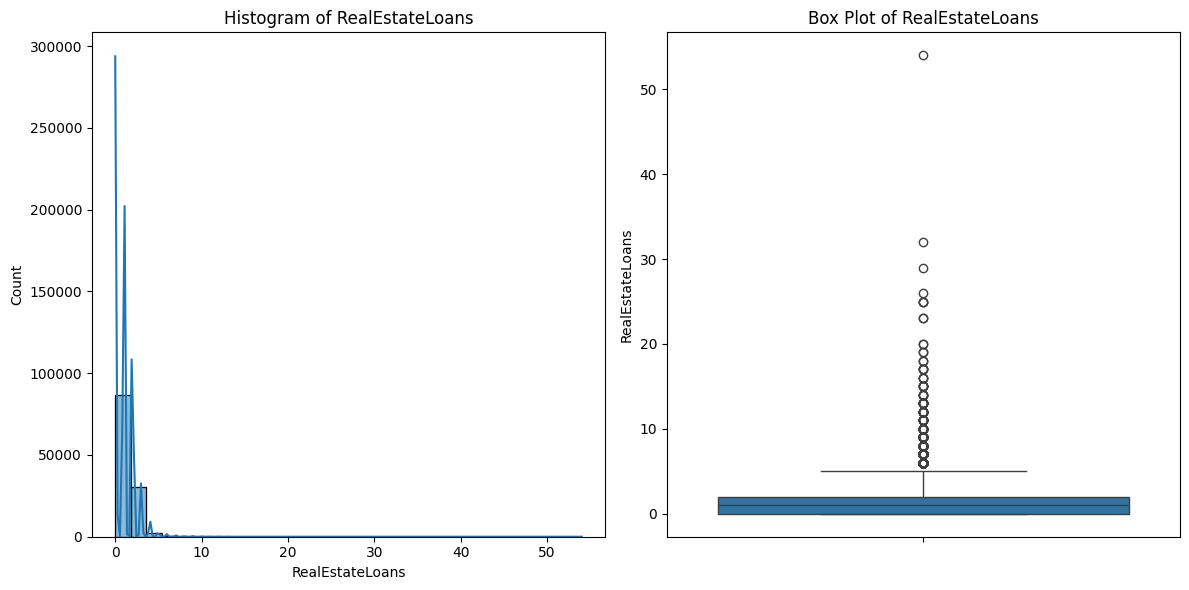


Analysis for PastDue60_89:

count    120000.000000
mean          0.238267
std           4.124034
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: PastDue60_89, dtype: float64


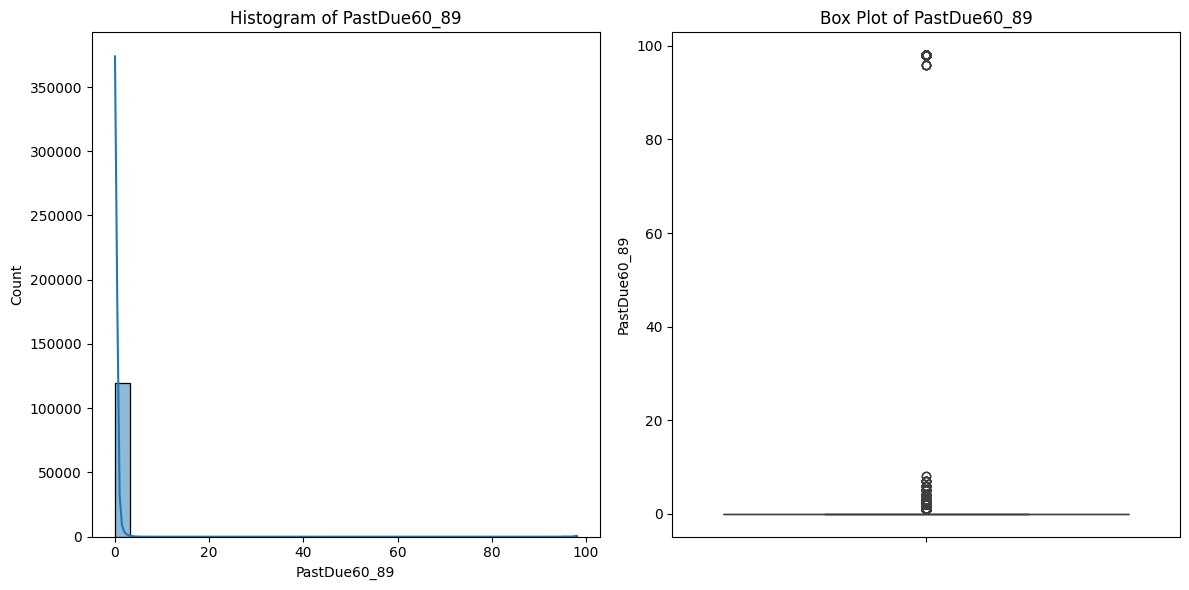

In [27]:
# Perform univariate analysis
univariate_analysis(train_original)

Most of the features are Highly right-skewed, with extreme outliers

# Data Preprocessing

- Drop rows with missing values
- Outlier handling
- Skewness correction
- Feature Scaling (Min-Max Scaling)

In [13]:
def preprocess_data(df, is_train=True, target_column=None, 
                     outlier_cols=None, skewness_cols=None, scale_cols=None, balance_data=False):
    """
    Function to preprocess data: handle missing values, outliers, skewness, feature scaling, and class imbalance.
    Args:
        df (pd.DataFrame): Input DataFrame (train or test set).
        is_train (bool): Whether the data is training data (default=True).
        target_column (str): Name of the target variable to exclude from transformations.
        outlier_cols (list): List of columns to apply outlier handling.
        skewness_cols (list): List of columns to apply skewness correction.
        scale_cols (list): List of columns to apply MinMax scaling.
        balance_data (bool): Whether to apply SMOTE to balance classes (only for training data).
    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    df = df.copy()

    # Drop missing values instead of imputing
    df.dropna(inplace=True)

    # Exclude target column from transformations
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_column and target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # Outlier removal
    if outlier_cols:
        for col in outlier_cols:
            if col in df.columns:
                lower, upper = np.percentile(df[col], [1, 99])
                df = df[(df[col] >= lower) & (df[col] <= upper)]  # Remove outliers

    # Skewness correction (Log transformation for positive values)
    if skewness_cols:
        for col in skewness_cols:
            if col in df.columns:
                df[col] = np.log1p(df[col])  # log1p to handle zero values

    # Feature Scaling (Min-Max Scaling)
    if scale_cols:
        scaler = MinMaxScaler()
        df[scale_cols] = scaler.fit_transform(df[scale_cols])

    # Handle class imbalance with SMOTE (Only for training data)
    if is_train and balance_data and target_column:
        X = df.drop(columns=[target_column])
        y = df[target_column]

        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        df = pd.DataFrame(X_resampled, columns=X.columns)
        df[target_column] = y_resampled

    return df

In [47]:
train_original.columns

Index(['Default', 'RevolvingUtil', 'age', 'PastDue30_59', 'DebtRatio',
       'Income', 'OpenCreditLines', 'PastDue90', 'RealEstateLoans',
       'PastDue60_89', 'Dependents'],
      dtype='object')

In [14]:
# Define columns for each transformation
outlier_cols = ['RevolvingUtil', 'age', 'PastDue30_59', 'DebtRatio', 'Income', 'OpenCreditLines', 
                'PastDue90', 'RealEstateLoans', 'PastDue60_89']
skewness_cols = ["RevolvingUtil", "DebtRatio", "Income"]
scale_cols = ['age', 'PastDue30_59', 'Income', 'OpenCreditLines', 'PastDue90', 'RealEstateLoans', 'PastDue60_89', 'Dependents']

In [15]:
# Apply preprocessing on training data with SMOTE
train_cleaned = preprocess_data(train_original, is_train=True, target_column="Default", 
                                outlier_cols=outlier_cols, skewness_cols=skewness_cols, 
                                scale_cols=scale_cols, balance_data=True)


In [15]:
# Check the transformed data
train_cleaned.head()

,RevolvingUtil,age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents,Default
0,0.031329,0.344262,0.0,0.010277,0.520321,0.083333,0.0,0.00,0.0,0.00,0.0
1,0.005186,0.508197,0.0,0.007871,0.706531,0.125000,0.0,0.00,0.0,0.00,0.0
2,0.017591,0.786885,0.0,0.197703,0.460224,0.375000,0.0,0.00,0.0,0.00,0.0
3,0.190098,0.131148,0.0,0.371736,0.635602,0.125000,0.0,0.25,0.0,0.00,0.0
4,0.001033,0.491803,0.0,0.235289,0.862255,0.791667,0.0,0.75,0.0,0.05,0.0


In [16]:
train_cleaned['Default'].value_counts()

Default
0.0    82123
1.0    82123
Name: count, dtype: int64

In [17]:
# split the train data into X and y (target)
X_train_prep, y_train_prep = train_cleaned.loc[:, train_cleaned.columns != 'Default'], train_cleaned['Default'].astype('int64')

In [18]:
y_train_prep

0         0
1         0
2         0
3         1
4         0
         ..
164241    1
164242    1
164243    1
164244    1
164245    1
Name: Default, Length: 164246, dtype: int64

## Models training

In [28]:
def evaluate_model(model, X_train, y_train, class_names):
    """
    Train the model using cross-validation and generate classification report, ROC Curve, confusion matrix, and Precision-Recall Curve.
    """
    # Cross-validation predictions
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_train, y_train, cv=kf, method="predict")
    y_prob = cross_val_predict(model, X_train, y_train, cv=kf, method="predict_proba") if hasattr(model, 'predict_proba') else None
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_train, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_train, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    if y_prob is not None:
        y_train_bin = label_binarize(y_train, classes=[0, 1])
        fpr, tpr, _ = roc_curve(y_train_bin, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()
    
    # Precision-Recall Curve
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_train, y_prob[:, 1])
        avg_precision = average_precision_score(y_train, y_prob[:, 1])
        
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()
    
    return model


==== Training and Evaluating LogisticRegression ====
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     82123
           1       0.76      0.73      0.74     82123

    accuracy                           0.75    164246
   macro avg       0.75      0.75      0.75    164246
weighted avg       0.75      0.75      0.75    164246



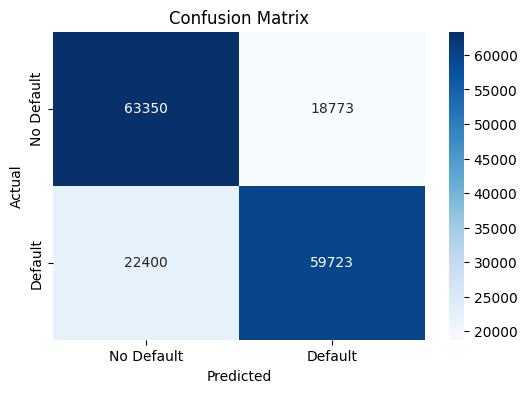

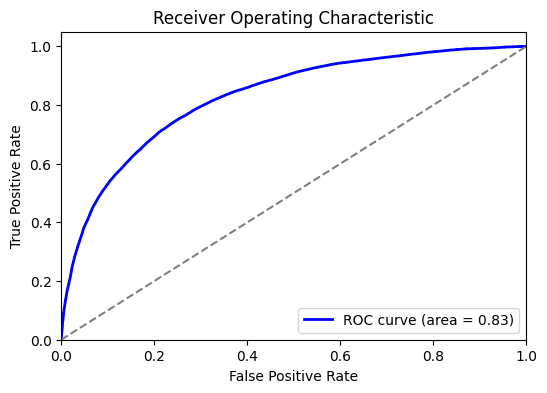

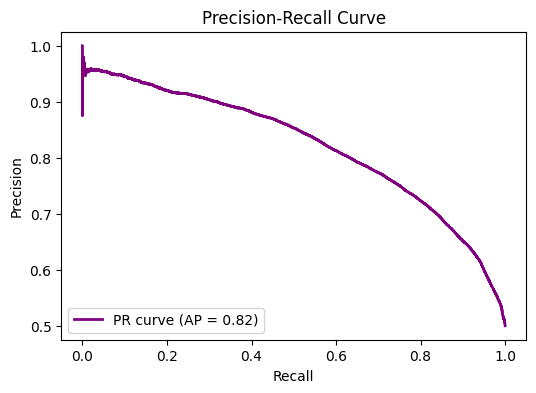

Model saved to: models\LogisticRegression_model.pkl

==== Training and Evaluating DecisionTree ====
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     82123
           1       0.91      0.94      0.93     82123

    accuracy                           0.92    164246
   macro avg       0.92      0.92      0.92    164246
weighted avg       0.92      0.92      0.92    164246



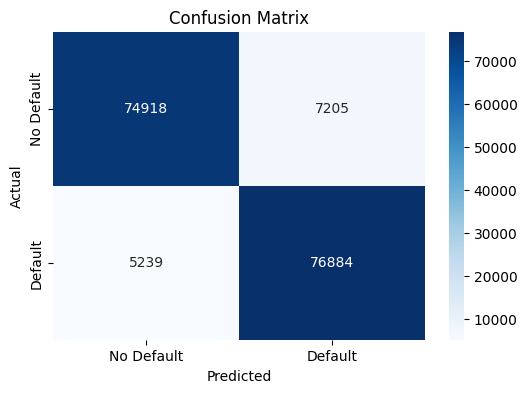

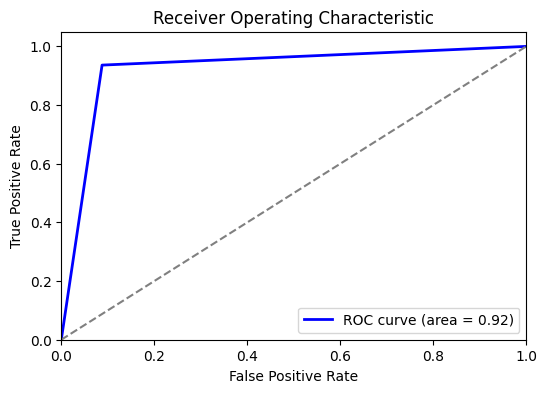

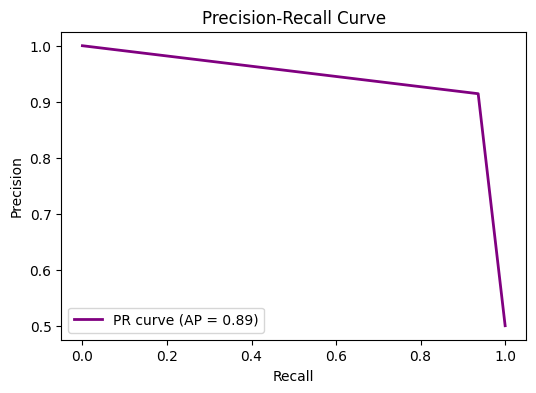

Model saved to: models\DecisionTree_model.pkl

==== Training and Evaluating RandomForest ====
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     82123
           1       0.96      0.97      0.96     82123

    accuracy                           0.96    164246
   macro avg       0.96      0.96      0.96    164246
weighted avg       0.96      0.96      0.96    164246



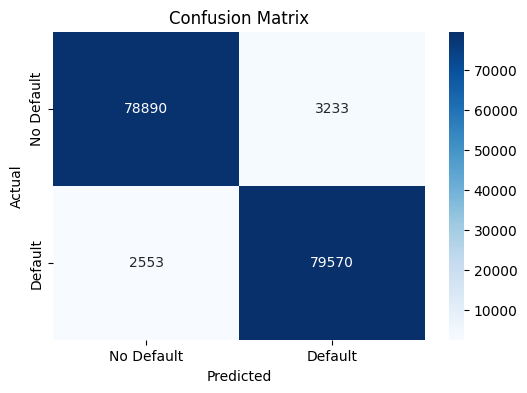

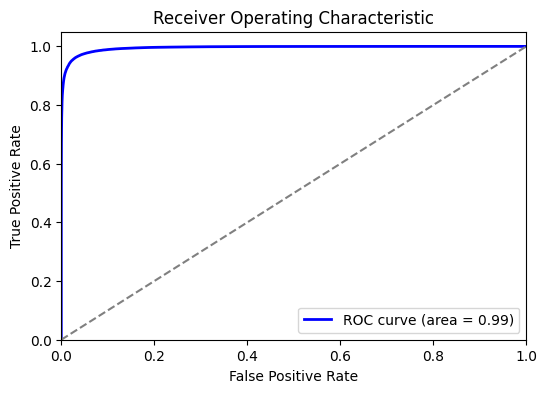

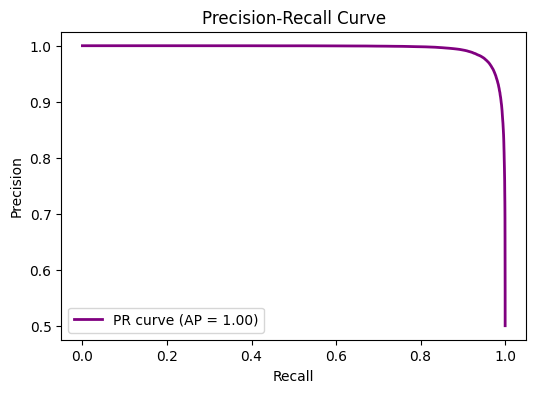

Model saved to: models\RandomForest_model.pkl

==== Training and Evaluating GradientBoosting ====
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     82123
           1       0.91      0.84      0.87     82123

    accuracy                           0.88    164246
   macro avg       0.88      0.88      0.88    164246
weighted avg       0.88      0.88      0.88    164246



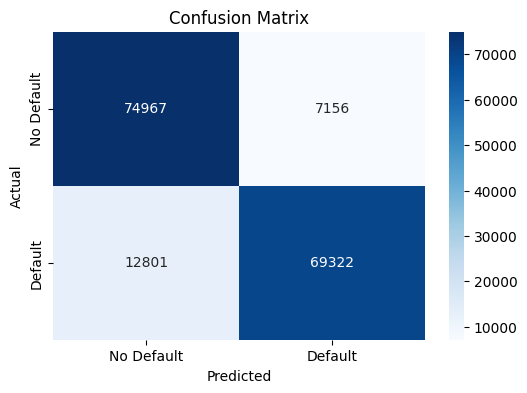

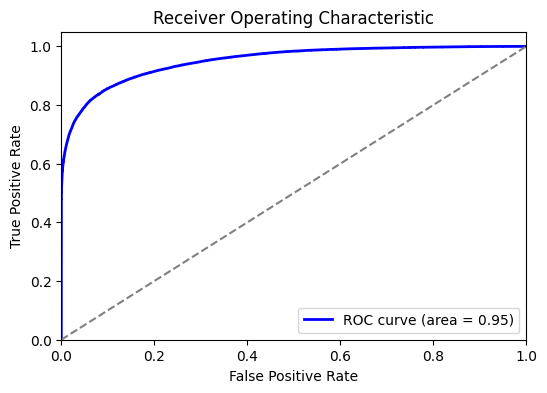

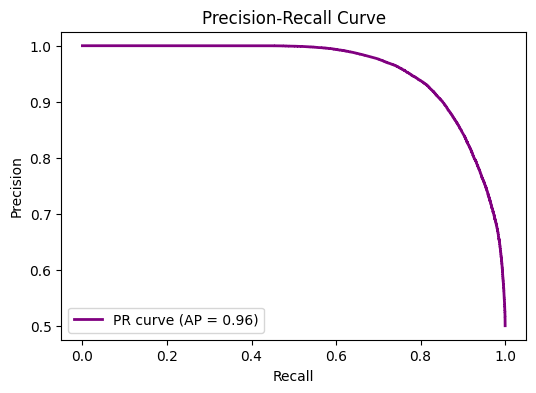

Model saved to: models\GradientBoosting_model.pkl

==== Training and Evaluating XGBoost ====


c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\give_me_some_credit\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:00:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\give_me_some_credit\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:00:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Classification\give_me_some_credit\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:00:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     82123
           1       0.98      0.92      0.95     82123

    accuracy                           0.95    164246
   macro avg       0.95      0.95      0.95    164246
weighted avg       0.95      0.95      0.95    164246



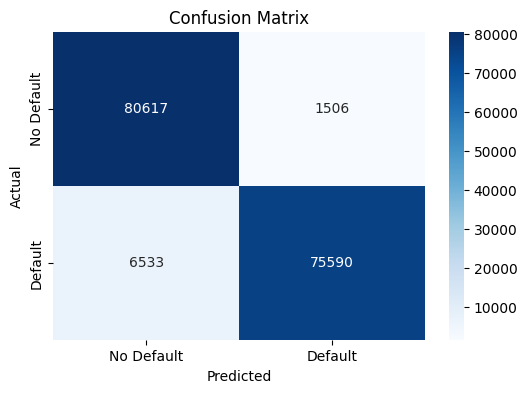

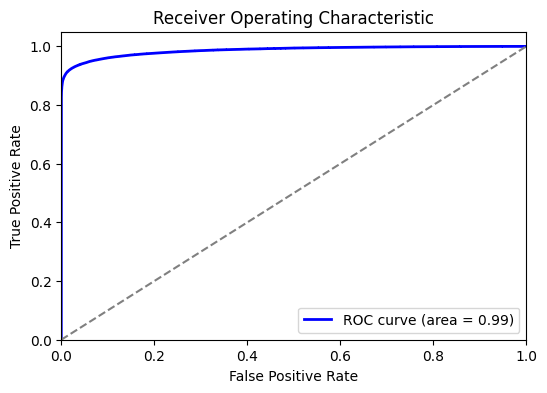

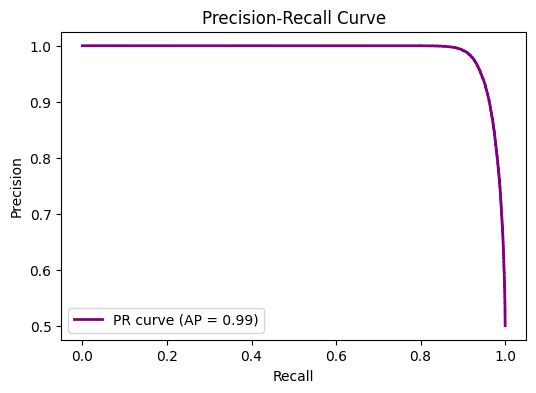

Model saved to: models\XGBoost_model.pkl


In [ ]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Class names
class_names = ["No Default", "Default"]

# Folder for saving models if it doesn't exist
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Train, evaluate, and save each model
for name, model in models.items():
    print(f"\n==== Training and Evaluating {name} ====")
    
    # Fit model on the full training set
    model.fit(X_train_prep, y_train_prep)

    # Evaluate the trained model using cross-validation
    evaluate_model(model, X_train_prep, y_train_prep, class_names=class_names)

    # Save model
    save_path = os.path.join(model_dir, f"{name}_model.pkl")
    joblib.dump(model, save_path)
    print(f"Model saved to: {save_path}")

## Model Performance Comparison (Training Set) 

| Model               | Accuracy | Precision (0/1)   | Recall (0/1)   | F1-score (0/1)   | ROC AUC |
|:--------------------|:--------:|:------------------|:---------------|:-----------------|:--------:|
| Logistic Regression |   0.75   | 0.74 / 0.76       | 0.77 / 0.73    | 0.76 / 0.74      |  0.83    |
| Decision Tree       |   0.92   | 0.93 / 0.91       | 0.91 / 0.93    | 0.92 / 0.92      |  0.92    |
| Random Forest       |   0.96   | 0.97 / 0.96       | 0.96 / 0.97    | 0.96 / 0.96      |  0.99    |
| Gradient Boosting   |   0.87   | 0.85 / 0.89       | 0.90 / 0.84    | 0.87 / 0.87      |  0.95    |
| MLP Classifier      |   0.80   | 0.79 / 0.82       | 0.82 / 0.78    | 0.81 / 0.80      |  0.89    |
| XGBoost             |   0.95   | 0.92 / 0.98       | 0.98 / 0.92    | 0.95 / 0.95      |  0.99    |

---

## Selected Models for Testing Phase

Based on their **high accuracy**, **balanced precision-recall**, and **strong ROC AUC scores**, the following three models have been selected for evaluation on the **testing set**:

1. **Random Forest Classifier** – Excellent balance of performance with minimal overfitting signs.
2. **XGBoost Classifier** – High precision and recall for both classes, with outstanding AUC.
3. **Gradient Boosting Classifier** – Slightly lower accuracy than RF/XGBoost but strong generalization ability.

These models demonstrated robust predictive power while maintaining interpretability and consistency across key metrics.

# Test the selected models on the test set

In [21]:
test_original.head()

,Default,RevolvingUtil,age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents
0,0.0,0.409323,48,0,0.263313,4750.0,12,0,1,1,1.0
1,0.0,0.162485,51,0,0.356338,3636.0,8,0,1,0,0.0
2,0.0,1.000000,36,0,4397.000000,NaN,3,0,2,0,0.0
3,0.0,1.000000,48,0,0.803906,3788.0,8,0,2,0,2.0
4,0.0,0.427488,32,0,0.385318,3500.0,3,0,2,0,0.0


In [22]:
# Apply preprocessing on training data with SMOTE
test_cleaned = preprocess_data(test_original, is_train=True, target_column="Default", 
                                outlier_cols=outlier_cols, skewness_cols=skewness_cols, 
                                scale_cols=scale_cols, balance_data=True)

In [23]:
# Check the transformed data
test_cleaned.head()

,RevolvingUtil,age,PastDue30_59,DebtRatio,Income,OpenCreditLines,PastDue90,RealEstateLoans,PastDue60_89,Dependents,Default
0,0.343109,0.393443,0.0,0.233738,0.601970,0.458333,0.0,0.25,1.0,0.05,0.0
1,0.150560,0.442623,0.0,0.304788,0.539092,0.291667,0.0,0.25,0.0,0.00,0.0
2,0.693147,0.393443,0.0,0.589954,0.548727,0.291667,0.0,0.50,0.0,0.10,0.0
3,0.355916,0.131148,0.0,0.325930,0.530124,0.083333,0.0,0.50,0.0,0.00,0.0
4,0.009566,0.114754,0.0,0.351461,0.487662,0.291667,0.0,0.25,0.0,0.10,0.0


In [24]:
test_cleaned['Default'].value_counts()

Default
0.0    20359
1.0    20359
Name: count, dtype: int64

In [25]:
# split the test data into X and y (target)
X_test_prep, y_test_prep = test_cleaned.loc[:, test_cleaned.columns != 'Default'], test_cleaned['Default'].astype('int64')

## Evaluate Models on the Test Set

In [26]:
def evaluate_model_on_test(model, X_test, y_test, class_names):
    """
    Evaluate a trained model on the test set and generate classification report, ROC Curve, confusion matrix, and Precision-Recall Curve.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    if y_prob is not None:
        y_test_bin = label_binarize(y_test, classes=[0, 1])
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

    # Precision-Recall Curve
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
        avg_precision = average_precision_score(y_test, y_prob[:, 1])

        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()


==== Evaluating RandomForest on Test Set ====


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.57      0.66     20359
           1       0.66      0.83      0.73     20359

    accuracy                           0.70     40718
   macro avg       0.71      0.70      0.70     40718
weighted avg       0.71      0.70      0.70     40718



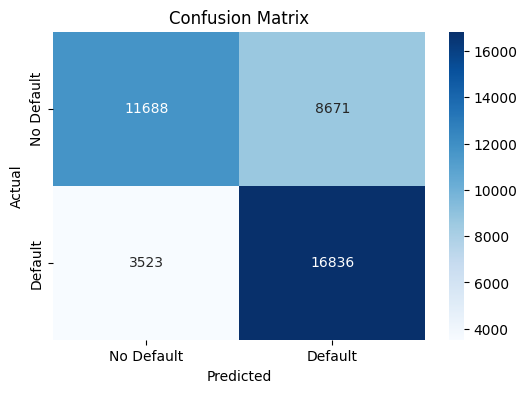

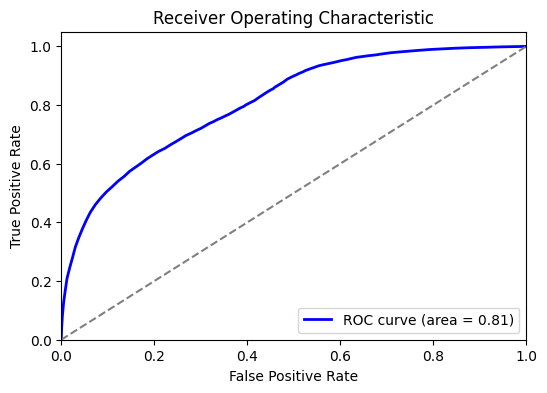

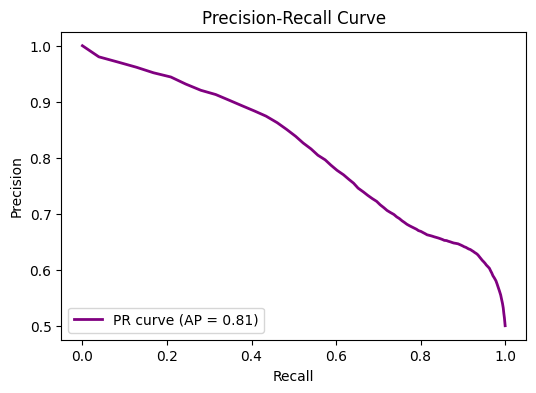


==== Evaluating XGBoost on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.40      0.56     20359
           1       0.62      0.97      0.75     20359

    accuracy                           0.68     40718
   macro avg       0.77      0.68      0.65     40718
weighted avg       0.77      0.68      0.65     40718



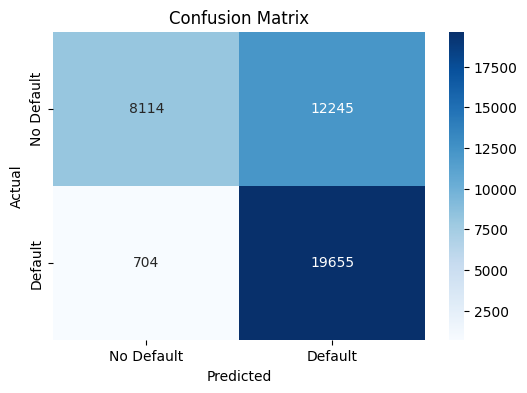

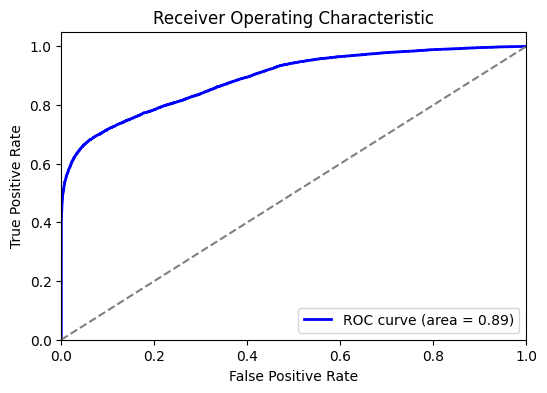

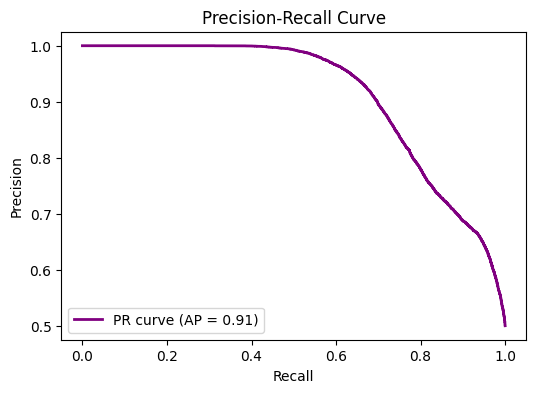


==== Evaluating GradientBoosting on Test Set ====
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.49      0.62     20359
           1       0.64      0.92      0.76     20359

    accuracy                           0.71     40718
   macro avg       0.75      0.71      0.69     40718
weighted avg       0.75      0.71      0.69     40718



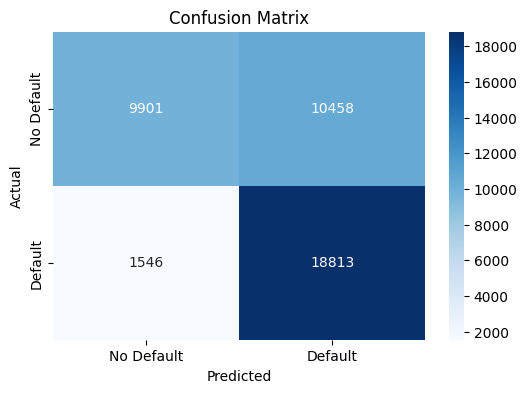

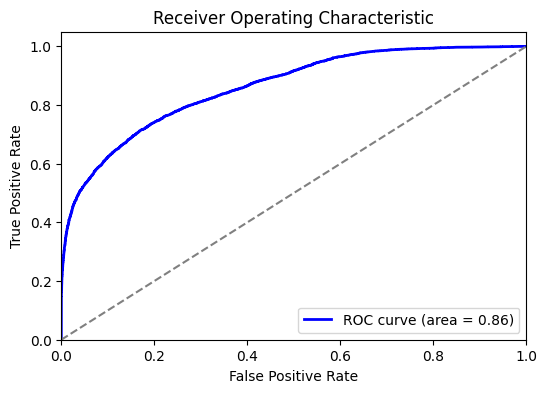

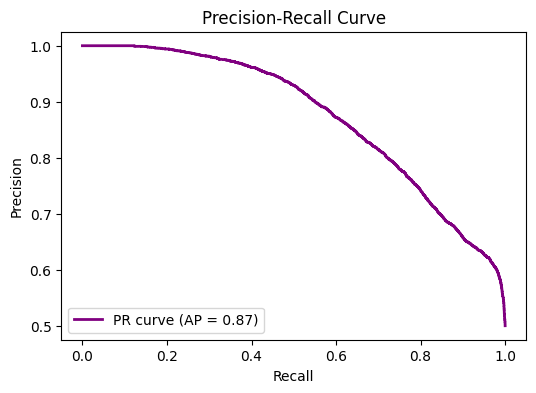

In [ ]:
# Class names
class_names = ["No Default", "Default"]

# Folder path
model_dir = "models"

# Models to evaluate
selected_models = ["RandomForest", "XGBoost", "GradientBoosting"]

# Evaluate saved models on test set
for name in selected_models:
    print(f"\n==== Evaluating {name} on Test Set ====")
    model_path = os.path.join(model_dir, f"{name}_model.pkl")
    
    if os.path.exists(model_path):
        loaded_model = joblib.load(model_path)
        evaluate_model_on_test(loaded_model, X_test_prep, y_test_prep, class_names=class_names)
    else:
        print(f"Model file not found: {model_path}. Skipping.")

Key Observations

- XGBoost achieved the highest ROC AUC (0.89) and PR AUC (0.91), indicating strong class separation and high relevance in ranking predictions.
- Gradient Boosting showed the best balance between precision and recall for the default class.
- Random Forest offered a more conservative balance, with slightly lower AUCs but comparable overall performance.